# main.ipynb
A notebook designing the substrate for the matching system

In [10]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [11]:
import pyphi
from substrate_modeler import unit, substrate
from matching.utils.convert import ces2df

from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [12]:
pyphi.compute.parallel.init(address='144.92.2.41:99990')

In [14]:
pyphi.config.PROGRESS_BARS

False

## Build substrate


- LGN->V1: paralell inputs, mismatch detector
- within V1: Grid with self loop and lateral excitation that gets weaker with distance. units always help eachother maintain their states
- V1->V2: contiguity detector
- within V2: self loop (only a single detector)
- V2->V1: state-dependent modulation (if ON: shift threshold to the left; if OFF: shift threshold to the right)

In [15]:
input_layer = ["L1", "L2", "L3", "L4", "L5", "L6", "L7", "L8", "L9"] 
layer_1 = ["A", "B", "C", "D", "E", "F", "G", "H", "I"] 
layer_2 = ["BCD", "CDE", "DEF", "EFG"] 
Layer_3 = ["V3"]

labels = input_layer + layer_1 + layer_2 + Layer_3
N = len(labels)
M = len(input_layer)

### Define LGN units
Each unit in the LGN has a self loop, and no other inputs. THey are modeled as simple sigmoids with a relatively low determinism. They will be outside the main entity anyways.

In [16]:
# parameters for LGN sigmoid
LGN_determinism = 3
LGN_threshold = 0.5
LGN_floor = 0.0
LGN_ceiling = 1.0

LGN_weights = [1.0]

# create the basic unit, which will be used to define each of the LGN units in our substrate. Thwy will just vary with regards to from whom they receive inputs, their label, and their index (see below)
LGN_unit = dict(
        input_weights=LGN_weights,
        determinism=LGN_determinism,
        threshold=LGN_threshold,
        floor=LGN_floor,
        ceiling=LGN_ceiling,
        ising = False
    )

# build the LGN units
LGN = [
    unit.Unit(
        index=i,
        label=labels[i],
        inputs=(i,),
        mechanism="sigmoid",
        params=LGN_unit,
        state=(0,),
        input_state =(0,)
    )
    for i in range(M)
]

# We now have a list of five identical (except their labels, inputs and indices) units that will form our input layer

### Define V1 units
V1 units are composed of two mechanisms, and they are modulated by V2.

First, they function as mismatch detectors with regards to the input from LGN. This means that they will be very strongly affected by inputs from the LGN if the LGN input is in a different state than the current state of the V1 unit. However, the LGN input has no effect on the state of the V1 unit if they are in the same state.

Second, the V1 units implement a function inspired by (or hypothesized to be found in) neocortex. Basically, units receive inputs from their (near and far) neighbors (strength dependent on distance, for example), but regardless off the states of the units, the inputs always contribut to keeping the V1 unit in its current state. This is implemented using a simple sigmoid function, where the inputs are coded using ising states and the sign of the connection weights depend on the states of the V1unit and the inputs. If the V1 unit and its input is in the same state, the input will be positive, but if they are in oposite states they will be engative (and weaker?).

Finally, the sigmoids are modulated by top down V2 input. The modulation is such that the threshold of the sigmoid is shifted depending on the state of the unit. If the unit is ON, then the threshold is shifted to the left (essentially increasing probability of firing). And oopposite for OFF

In [17]:
# parameters for sigmoidal subunit

# V1_determinism = 4
V1_determinism = 1

V1_threshold = 0.0
V1_floor = 0.01
V1_ceiling = 0.99

# define mapping to scale weight based on (unit_state, input_state)
V1_weight_scale_mapping = {
    (0, 0): 1.0,
    (1, 0): 0.5,
    (0, 1): 0.75,
    (1, 1): 1.5
}

self_loop = 0.5
lateral = 0.25
V1_weights = [
    lateral,  # near neighbor
    self_loop,  # self
    lateral,  # near neighbor
    0.01,  # V3
]

V1_sigmoid = dict(
        input_weights=V1_weights,
        determinism=V1_determinism,
        threshold=V1_threshold,
        weight_scale_mapping=V1_weight_scale_mapping,
        floor=V1_floor,
        ceiling=V1_ceiling,
)


# parameters for mismatch detector subunit# parameters for sigmoidal subunit
V1_mm_floor = 0.01
V1_mm_ceiling = 0.99
V1_input = dict(
    floor=V1_mm_floor,
    ceiling=V1_mm_ceiling,
    bias=0.0
)

In [18]:

# feedback amplification
feedback = (N-1,)
V1_sigmoid_inputs = (17,9,10,11,12,13,14,15,16,17,9)

V1 = [
    unit.CompositeUnit(
        index=M + i,
        label=labels[M + i],
        state=(0,),
        units=[
            unit.Unit(
                index=M + i,
                label = labels[M + i],
                state=(0,),
                inputs=V1_sigmoid_inputs[i : i + 3] + feedback,
                input_state=(0,)*4,
                mechanism="resonnator",#"sigmoid",#
                params = V1_sigmoid, 
            ),
            unit.Unit(
                index=M + i,
                label = labels[M + i],
                state=(0,),
                inputs = (i,),
                input_state=(0,),
                mechanism = "mismatch_corrector",
                params = V1_input,
            )
            ],  # FB_sigmoid
        mechanism_combination="selective",
    )
    for i in range(len(layer_1))
] 

# V2
The V2 units are segment detectors. They also have a sigmoidal self-loop.

Each detector is selective to a single segment state in V1 where exactly one contiuous segment is present. They implement selective "conjunction" mechanisms---only active when their preferred state is in the inputs. 


In [19]:
# Define sets of V1 states the V2 gate is selective to
V1_segments = [(0, 1, 1, 1, 0)]

In [20]:
# Gabor-like detectors
detector_floor = 0.01
detector_ceiling = 0.99
detector_selectivity = 5.0

V2_detector = dict(
    floor=detector_floor,
    ceiling=detector_ceiling,
    selectivity=detector_selectivity,
    pattern_selection=V1_segments,
)

# self loop for V2, based on a sigmoid
self_floor = 0.01
self_ceiling = 0.2
self_determinism = 1
self_threshold = 0.5

self_weights = [1.0, 0.5]

self_sigmoid = dict(
    input_weights=self_weights,
    determinism=self_determinism,
    threshold=self_threshold,
    weight_scale_mapping=V1_weight_scale_mapping,
    floor=self_floor,
    ceiling=self_ceiling,
)


In [21]:
first_i = len(input_layer) + len(layer_1)
layer_1_indices = tuple(range(M,M*2))

# combining the mechanisms into a composite unit
V2 = [
    unit.CompositeUnit(
        index=first_i + i,
        label=labels[first_i + i],
        state=(0,),
        units=[
            unit.Unit(
                index=first_i + i,
                label=labels[first_i + i],
                state=(0,),
                inputs=layer_1_indices[i+1:6+i],
                input_state=(0,)*5,
                mechanism="sor",
                params=V2_detector,
            ),
            unit.Unit(
                index=first_i + i,
                label=labels[first_i + i],
                state=(0,),
                inputs=(first_i + i,) + feedback,
                input_state=(0,)*2,
                mechanism="resonnator",
                params=self_sigmoid
            )
        ],
        mechanism_combination="serial",
    )
    for i in range(len(layer_2))
]

# V3
The V3 unit is a detector over the V2 units. It also has a sigmoidal self-loop.

The detector is selective to any state of the V2 units where exactly one of them is ON (indicating a segment is present in V1). It implements "disjunction" mechanism---active whenever one of its preferred states are on its inputs. 


In [22]:
# Define sets of V1 states the V2 gate is selective to
V2_states = [
    (1,0,0,0,),
    (0,1,0,0,),
    (0,0,1,0,),
    (0,0,0,1,),
]

In [23]:
# Gabor-like detectors
detector_floor = 0.01
detector_ceiling = 0.99
detector_selectivity = 5.0

V3_detector = dict(
    floor=detector_floor,
    ceiling=detector_ceiling,
    selectivity=detector_selectivity,
    pattern_selection=V2_states,
)

# self loop for V2, based on a sigmoid
self_floor = 0.01
self_ceiling = 0.2
self_determinism = 1
self_threshold = 0.5

self_weights = [1.0]

self_sigmoid = dict(
    input_weights=self_weights,
    determinism=self_determinism,
    threshold=self_threshold,
    weight_scale_mapping=V1_weight_scale_mapping,
    floor=self_floor,
    ceiling=self_ceiling,
)

In [24]:
layer_2_indices = tuple(range(first_i,first_i+4))

# combining the mechanisms into a composite unit
V3 = [
    unit.CompositeUnit(
        index=N-1,
        label=labels[N-1],
        state=(0,),
        units=[
            unit.Unit(
                index=N-1,
                label=labels[N-1],
                state=(0,),
                inputs=layer_2_indices,
                input_state=(0,)*4,
                mechanism="sor",
                params=V3_detector
            ),
            unit.Unit(
                index=N-1,
                label=labels[N-1],
                state=(0,),
                inputs=(N-1,),
                input_state=(0,),
                mechanism="resonnator",
                params=self_sigmoid
            )
        ],
        mechanism_combination="serial",
    )
]

In [25]:
units = LGN+V1+V2+V3

## create subsystems and compute some concepts

In [26]:
def create_subsystems(state, units):
    full_substrate = substrate.Substrate(units, state, implicit=True)
    V1 = full_substrate.isolate_subset(tuple(range(9,18)))
    V1_w_inputs = full_substrate.isolate_subset(tuple(range(18)))
    one_detector = full_substrate.isolate_subset((9,10,11,12,13,18))
    all_detectors = full_substrate.isolate_subset(tuple(range(9,23)))
    pyramid = full_substrate.isolate_subset(tuple(range(9,23)))
    return (
        full_substrate.subsystem(nodes=tuple(range(8,21))),
        V1.subsystem(),
        V1_w_inputs.subsystem(nodes=tuple(range(8,16))),
        one_detector.subsystem(),
        all_detectors.subsystem(),
        pyramid.subsystem()
    )

In [27]:
def concepts(
    subsystem,
    mechanisms,
    purviews=False,
    cause_purviews=False,
    effect_purviews=False
):
    if not purviews:
        purviews = [purviews]*len(mechanisms)
    if not cause_purviews:
        cause_purviews = [cause_purviews]*len(mechanisms)
    if not effect_purviews:
        effect_purviews = [effect_purviews]*len(mechanisms)
        
    return [
        subsystem.concept(
            mechanism,
            purview,
            cause_purview,
            effect_purview
        )
        for (
            mechanism,
            purview,
            cause_purview,
            effect_purview
        ) in tqdm(
            zip(mechanisms,purviews,cause_purviews,effect_purviews),
            total=len(mechanisms)
        )
    ]


### All off

In [31]:

mechanisms = [(5,),(4,5),(4,5,6),(3,4,5,6),(3,4,5,6,7),]#(2,3,4,5,6,7),(1,2,3,4,5,6,7)]

In [32]:
state = (0,)*23
(
    full_substrate,
    V1,
    V1_w_inputs,
    one_detector,
    all_detectors,
    pyramid
) = create_subsystems(state, units)

In [33]:
cons = concepts(V1,mechanisms)
ces2df(pyphi.models.CauseEffectStructure(cons,subsystem=V1))

  0%|          | 0/5 [00:00<?, ?it/s]

,mechanism,mechanism_state,phi,cause_purview,cause_state,cause_phi,effect_purview,effect_state,effect_phi
0,F|,0,0.186485,F|,0,0.186485,F|,0,0.186485
1,E|F,00,0.109100,E|F,00,0.109100,E|F,00,0.114861
2,E|F|G,000,0.079727,F|,0,0.221913,F|,0,0.079727
3,D|E|F|G,0000,0.057916,E|F,00,0.125731,E|F,00,0.057916
4,D|E|F|G|H,00000,0.080312,E|F|G,000,0.080312,E|F|G,000,0.084145


### All on

In [34]:
state = (1,)*23
(
    full_substrate,
    V1,
    V1_w_inputs,
    one_detector,
    all_detectors,
    pyramid
) = create_subsystems(state, units)

In [35]:
cons_all_on = concepts(V1,mechanisms)
ces2df(pyphi.models.CauseEffectStructure(cons_all_on,subsystem=V1))

  0%|          | 0/5 [00:00<?, ?it/s]

,mechanism,mechanism_state,phi,cause_purview,cause_state,cause_phi,effect_purview,effect_state,effect_phi
0,F|,1,0.0,G|,0,0.0,G|,0,0.0
1,E|F,11,0.0,D|E|F|G,0000,0.0,D|E|F|G,0000,0.0
2,E|F|G,111,0.0,D|E|F|G|H,00000,0.0,D|E|F|G|H,00000,0.0
3,D|E|F|G,1111,0.0,D|E|F|G|H,00000,0.0,D|E|F|G|H,00000,0.0
4,D|E|F|G|H,11111,0.0,D|E|F|G|H,00000,0.0,D|E|F|G|H,00000,0.0


### segment ON

In [36]:
state = (0,0,0,1,1,1,0,0,0)*2+(0,0,0,1,1)
(
    full_substrate,
    V1,
    V1_w_inputs,
    one_detector,
    all_detectors,
    pyramid
) = create_subsystems(state, units)

In [ ]:
cons_segment = concepts(V1,mechanisms)
ces2df(pyphi.models.CauseEffectStructure(cons_segment,subsystem=V1))

  0%|          | 0/5 [00:00<?, ?it/s]

### heterogenous

In [ ]:
state = (0,1,0,1,0,1,0,1,0)*2+(0,0,0,0,0)
(
    full_substrate,
    V1,
    V1_w_inputs,
    one_detector,
    all_detectors,
    pyramid
) = create_subsystems(state, units)

In [ ]:
cons_hetero = concepts(V1,[(4,),(3,4),(2,3,4),(2,3,4,5),(2,3,4,5,6),(2,3,4,5,6,7)])
ces2df(pyphi.models.CauseEffectStructure(cons_hetero,subsystem=V1))

In [51]:
def create_substrates(state, units):
    full_substrate = substrate.Substrate(units, state, implicit=True)
    V1 = full_substrate.isolate_subset(tuple(range(9,18)))
    V1_w_inputs = full_substrate.isolate_subset(tuple(range(18)))
    one_detector = full_substrate.isolate_subset((9,10,11,12,13,18))
    all_detectors = full_substrate.isolate_subset(tuple(range(9,23)))
    pyramid = full_substrate.isolate_subset(tuple(range(9,23)))
    return (
        full_substrate,
        V1,
        V1_w_inputs,
        one_detector,
        all_detectors,
        pyramid
    )

In [63]:
state = (0,1,0,1,0,1,0,1,0)*2+(0,0,0,0,0)
(
    full_substrate,
    V1,
    V1_w_inputs,
    one_detector,
    all_detectors,
    pyramid
) = create_substrates(state, units)

In [78]:
V1.subsystem().concept((3,4,5,6))

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Distinction: mechanism = [D,E,F,G], state = [1, 0, 1, 0]
                  φ = 0.0464433771633                   
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                 MIC                                  MIE                 
┌───────────────────────────────────┐┌───────────────────────────────────┐
│  φ = 0.0576384006008              ││  φ = 0.0464433771633              │
│  Normalized φ = 0.0144096001502   ││  Normalized φ = 0.0077405628605   │
│  Purview: [D,F]                   ││  Purview: [E,F,G]                 │
│  Specified state:                 ││  Specified state:                 │
│  ┌───────────────────────────┐    ││  ┌─────────────────────────────┐  │
│  │      Specified CAUSE      │    ││  │       Specified EFFECT      │  │
│  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │    ││  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │  │
│  │ CAUSE:  (1, 1)            │    ││  │ EFFECT:  (0, 1, 0) 

In [34]:
ces2df(pyphi.models.CauseEffectStructure(cons,subsystem=V1))

,mechanism,mechanism_state,phi,cause_purview,cause_state,cause_phi,effect_purview,effect_state,effect_phi
0,D|,0,0.186485,D|,0,0.186485,D|,0,0.186485
1,C|D,00,0.109100,C|D,00,0.109100,C|D,00,0.114861
2,B|C|D,000,0.079727,C|,0,0.221913,C|,0,0.079727
3,B|C|D|E,0000,0.057916,C|D,00,0.125731,C|D,00,0.057916
4,B|C|D|E|F,00000,0.080312,C|D|E,000,0.080312,C|D|E,000,0.084145
5,B|C|D|E|F|G,000000,0.051032,C|D|E|F,0000,0.051032,C|D|E|F,0000,0.061125


In [26]:
V1.subsystem()

Subsystem(A, B, C, D, E, F, G, H)

In [24]:
state = (1,1,1,0,0,0,0,0)*2+(1,0,0,0,1)
full_substrate = substrate.Substrate(LGN+V1+V2+V3, state, implicit=True)
V1_substrate = full_substrate.isolate_subset((8,9,10,11,12,13,14,15))
V1_substrate.units[1].tpm[(1,1,1)]

ExplicitTPM(
[0.81121254]
)

In [29]:
state = (1,0,1,0,0,0,0,0)+(1,1,1,0,0,0,0,0)+(1,0,0,0,1)
full_substrate = substrate.Substrate(LGN+V1+V2+V3, state, implicit=True)
V1_substrate = full_substrate.isolate_subset((8,9,10,11,12,13,14,15))
V1_substrate.units[1].tpm

ExplicitTPM(
[[[[0.5]
   [0.5]]

  [[0.5]
   [0.5]]]


 [[[0.5]
   [0.5]]

  [[0.5]
   [0.5]]]]
)

In [34]:
state = (0,1,1,1,0,0,0,0)+(0,1,1,1,0,0,0,0)+(1,0,0,0,1)
full_substrate = substrate.Substrate(LGN+V1+V2+V3, state, implicit=True)
V1_substrate = full_substrate.isolate_subset((8,9,10,11,12,13,14,15,16))
V1_substrate.units[-1].tpm[(0,1,1,1,0,1)]

ExplicitTPM(
[0.99144342]
)

(1,)
(1, 1, 1, 1, 1)
(1, 8, 9, 10, 20)
(0, 4)
same
ExplicitTPM(
[[[[[[0.186595  ]
     [0.19097992]]

    [[0.32121046]
     [0.3276165 ]]]


   [[[0.49632507]
     [0.50367493]]

    [[0.6723835 ]
     [0.67878954]]]]



  [[[[0.32121046]
     [0.3276165 ]]

    [[0.49632507]
     [0.50367493]]]


   [[[0.6723835 ]
     [0.67878954]]

    [[0.80902008]
     [0.813405  ]]]]]




 [[[[[0.186595  ]
     [0.19097992]]

    [[0.32121046]
     [0.3276165 ]]]


   [[[0.49632507]
     [0.50367493]]

    [[0.6723835 ]
     [0.67878954]]]]



  [[[[0.32121046]
     [0.3276165 ]]

    [[0.49632507]
     [0.50367493]]]


   [[[0.6723835 ]
     [0.67878954]]

    [[0.80902008]
     [0.813405  ]]]]]]
)
not same
same
not same
same
same
same
same
same
[[[[0.18878746]
   [0.32441348]]

  [[0.5       ]
   [0.67558652]]]


 [[[0.32441348]
   [0.5       ]]

  [[0.67558652]
   [0.81121254]]]]
[(0, 1, 7), (0, 1, 2), (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6), (5, 6, 7), (0, 6, 7)]
[1, 1, 1, 0, 0, 0, 0, 0]


In [66]:
V1_substrate.units[1].inputs

(0, 1, 2)

In [67]:
%debug

> /Volumes/scratch/wmayner/projects/matching/data/substrate_modeler/substrate_modeler/substrate.py(322)expand_unit_tpm_dimensions()
    320         input_indices = unit.inputs
    321         new_shape = np.ones(len(self), dtype=int)
--> 322         new_shape[list(input_indices)] = unit_tpm.shape[:-1]
    323         return unit_tpm.reshape(new_shape)
    324 



ipdb>  unit_tpm.shape


(2, 2, 2)


ipdb>  new_shape 


array([1, 1, 1, 1, 1, 1, 1, 1])


ipdb>  list(input_indices)


*** Error in argument: '(input_indices)'


ipdb>  input_indices


(0, 1, 7)


ipdb>  n


In [67]:
network = full_substrate.network()

In [69]:
tpm = network.tpm.marginalize_out((0,1,2,3,4,5,6,7))

In [72]:
tpm.shape

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 21)

In [56]:
full_substrate.tpm

[array([[[[[[[[[[[[[[[[[[[[[[0.81757448, 0.18242552]]]]]]]]]]]]]]]]]]]]],
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
        [[[[[[[[[[[[[[[[[[[[[0.18242552, 0.81757448]]]]]]]]]]]]]]]]]]]]]]),
 array([[[[[[[[[[[[[[[[[[[[[[0.81757448, 0.18242552]]]]]]]]]]]]]]]]]]]],
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
         [[[[[[[[[[[[[[[[[[[[0.18242552, 0.81757448]]]]]]]]]]]]]]]]]]]]]]),
 array([[[[[[[[[[[[[[[[[[[[[[0.81757448, 0.18242552]]]]]]]]]]]]]]]]]]],
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
          [[[[[[[[[[[[[[[[[[[0.18242552, 0.81757448]]]]]]]]]]]]]]]]]]]]]]),
 array([[[[[[[[[[[[[[[[[[[[[[0.81757448, 0.18242552]]]]]]]]]]]]]]]]]],
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
           [[[[[[[[[[[[[[[[[[0.18242552, 0.81757448]]]]]]]]]]]]]]]]]]]]]]),
 array([[[[[[[[[[[[[[[[[[[[[[0.81757448, 0.18242552]]]]]]]]]]]]]]]]],
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
            [[[[[[[[[[[[[[[[[0.18242552, 0.81757448]]]]]]]]]]]]]]]]]]]]]]),
 array([[[[[[[[[[[[[[[[[[[[[[0.81757448, 0.18242552]]]]]]]]]]]]]]]],
 
 
 
 
 
 

## Obtain triggered systems for the detector

In [35]:
pyphi.config.PARTITION_TYPE = 'TRI'
pyphi.config.PROGRESS_BARS = False


In [38]:
t = subs.dynamic_tpm

Not implemented for implicit substrates


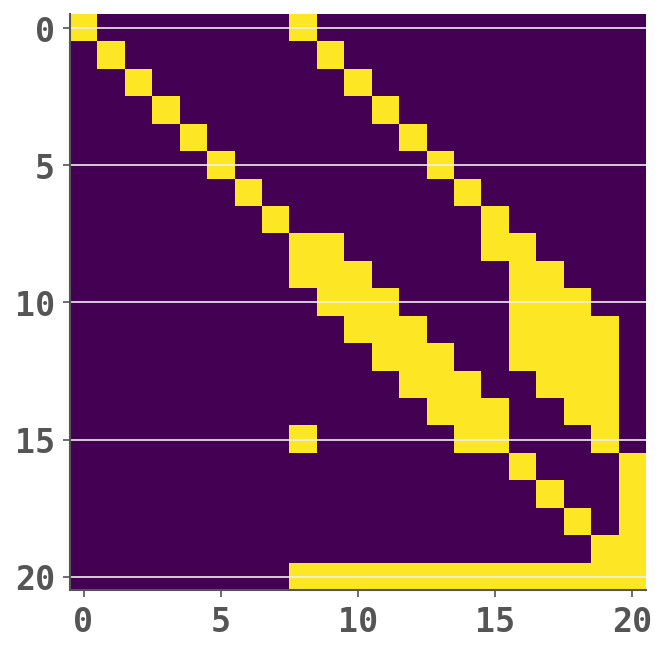

In [39]:
plt.imshow(subs.cm)

In [40]:
net = subs.network(
    (0,)*len(subs)
)

In [41]:
net


Network(
ImplicitTPM((L1, L2, L3, L4, L5, L6, L7, L8, A, B, C, D, E, F, G, H, BCD, CDE, DEF, EFG, V3)),
cm=[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [46]:
system = subs.subsystem(
    (0,)*len(subs), (8,9,10,11,12,13,14,15,16,17,18,19,20)
)

In [56]:
system

Subsystem(A, B, C, D, E, F, G, H, BCD, CDE, DEF, EFG, V3)

In [48]:
system.concept((10,11),purviews=((10,11),))

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Distinction: mechanism = [C,D], state = [0, 0]
             φ = 0.1090999288903              
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                 MIC                                  MIE                 
┌───────────────────────────────────┐┌───────────────────────────────────┐
│  φ = 0.1090999288903              ││  φ = 0.1148614475477              │
│  Normalized φ = 0.0545499644451   ││  Normalized φ = 0.0574307237739   │
│  Purview: [C,D]                   ││  Purview: [C,D]                   │
│  Specified state:                 ││  Specified state:                 │
│  ┌───────────────────────────┐    ││  ┌──────────────────────────┐     │
│  │      Specified CAUSE      │    ││  │     Specified EFFECT     │     │
│  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │    ││  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │     │
│  │ CAUSE:  (0, 0)            │    ││  │ EFFECT:  (0, 0)          │     │
│  │  